# Исследование сервиса аренды самокатов

В нашем распоряжении данные сервиса аренды самокатов о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируем данные и проверим некоторые гипотезы, которые могут помочь бизнесу вырасти.

План работы следующий:
1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Объединение данных
5. Создание дополнительных датафреймов
6. Подсчет выручки
7. Проверка гипотез

## Загрузка данных

Для начала импортируем нужные библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

Теперь сохраним данные в соответствующие переменные и изучим основную информацию о них.

### Пользователи

In [2]:
try:
    users = pd.read_csv('/Users/macbook/practicum/projects/scooters_project/users_go.csv')
except:
    users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [4]:
users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


Датафрейм содержит информацию о более чем полутора тысячах пользователей.

Согласно документации к данным столбцы содержат следующие данные:
* `user_id` - уникальный идентификатор пользователя
* `name` - имя пользователя
* `age` - возраст
* `city` - город
* `subscription_type` - тип подписки (free, ultra)

### Поездки

In [5]:
try:
    rides = pd.read_csv('/Users/macbook/practicum/projects/scooters_project/rides_go.csv')
except:
    rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')

In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [7]:
rides.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


Датафрейм содержит информацию о восемнадцати тысячах поездок.

Согласно документации к данным столбцы содержат следующие данные:
* `user_id` - уникальный идентификатор пользователя
* `distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах)
* `duration` - продолжительность сессии (в минутах)
* `date` - дата совершения поездки

### Подписки

In [8]:
try:
    subscriptions = pd.read_csv('/Users/macbook/practicum/projects/scooters_project/subscriptions_go.csv')
except:
    subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

In [9]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [10]:
subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Датафрейм содержит информацию о двух типах подписки.

Согласно документации к данным столбцы содержат следующие данные:
* `subscription_type` - тип подписки
* `minute_price` - стоимость одной минуты поездки по данной подписке
* `start_ride_price` - стоимость начала поездки
* `subscription_fee` - стоимость ежемесячного платежа

## Предобработка данных

### Изменение типов данных

Приведем данные к соотвествующему типу.

В датафрейме Поездки в столбце `date` тип данных необходимо заменить на `datetime`.

In [11]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y.%m.%d')

Убедимся в том, что тип данных изменился на нужный.

In [12]:
rides['date'].dtype.name

'datetime64[ns]'

### Добавление столбцов

Проверим, за какой период предоставлены данные в датафрейме Поездки.

In [13]:
rides['date'].min()

Timestamp('2021-01-01 00:00:00')

In [14]:
rides['date'].max()

Timestamp('2021-12-30 00:00:00')

Данные предоставлены за один год - 2021 - поэтому мы сможем добавить столбец с дополнительной информацией о месяце поездки, не рискуя склеить данные за несколько лет.

In [15]:
rides['month'] = rides['date'].dt.month

Проведем проверку того, что новый столбец корректно отображает месяц поездки.

In [16]:
rides.sample(5)

,user_id,distance,duration,date,month
9012,887,2183.841102,19.955930,2021-10-15,10
533,59,3016.002849,17.867834,2021-08-16,8
11771,1085,4341.870514,24.324249,2021-06-07,6
15090,1322,2545.884406,15.910933,2021-08-15,8
16875,1449,3614.930193,23.459721,2021-08-05,8


### Работа с пропусками

Проверим, есть ли пропуски в датафреймах.

In [17]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [18]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [19]:
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Проверка показала, что пропущенных значений в датафреймах нет.

### Обработка дубликатов

Проверим датафреймы на наличие дубликатов.

In [20]:
users.duplicated().sum()

31

In [21]:
rides.duplicated().sum()

0

In [22]:
subscriptions.duplicated().sum()

0

В датафрейме Пользователи есть 31 дубликат. Это небольшое количество по сравнению с размером датафрейма, поэтому мы просто удалим эти дубликаты.

In [23]:
users = users.drop_duplicates()

## Исследовательский анализ данных

Проанализируем информацию в датафреймах.

### Частота встречаемости городов

In [24]:
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

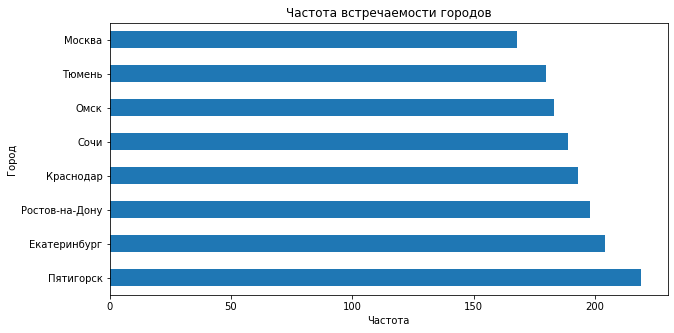

In [25]:
users['city'].value_counts().plot(kind='barh', figsize=(10,5))
plt.title('Частота встречаемости городов')
plt.xlabel('Частота')
plt.ylabel('Город')
plt.show()

Из приведенных выше данных и графика можно сделать вывод о том, что в датафрейме распределение пользователей по городам достаточно равномерное.

Больше всего пользователей в Пятигорске - 219 человек, а меньше всего в Москве - 168.

### Соотношение пользователей с подпиской и без подписки

In [26]:
users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

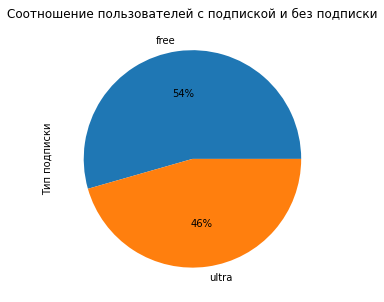

In [27]:
users['subscription_type'].value_counts().plot(y='subscription_type', kind='pie', figsize=(5,5), autopct = "%.f%%")
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.ylabel('Тип подписки')
plt.show()

Исходя из приведенных выше данных и графика можно прийти к выводу о том, что большинство пользователей пользуются сервисом без подписки.

При этом разница в поцентном соотношении между пользователями с подпиской и без небольшая - 46% против 54%, соответственно.

### Распределение возраста пользователей

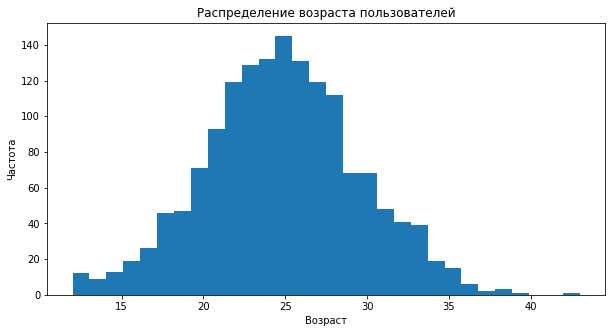

In [28]:
users['age'].plot(kind='hist', bins=30, figsize=(10,5))
plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

На основе графика выше можно сделать вывод о том, распределение возраста пользователей напоминает нормальное и что большая часть пользователей находится в возрасте от 20 до 30 лет, а пользователй старше 40 лет практически нет.

### Расстояние, которое пользователь преодолел за одну поездку

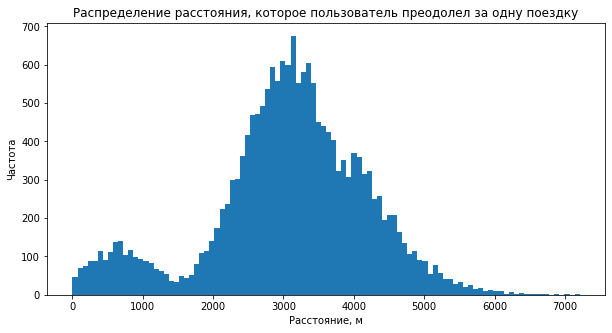

In [29]:
rides['distance'].plot(kind='hist', bins=100, figsize=(10,5))
plt.title('Распределение расстояния, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние, м')
plt.ylabel('Частота')
plt.show()

Из графика можно заключить, что распределение расстояния, которое пользователь преодолел за одну поездку, напоминает нормальное и что пользователи совершают поездки в основном от двух до четырех километров.

### Продолжительность поездок

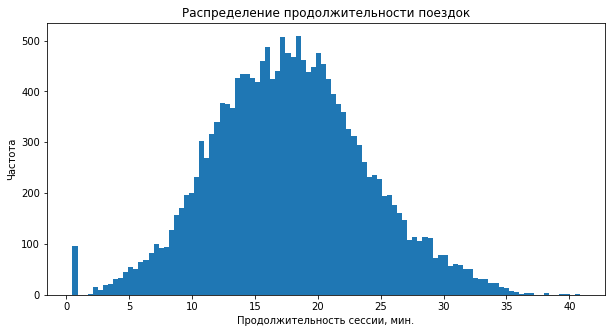

In [30]:
rides['duration'].plot(kind='hist', bins=100, figsize=(10,5))
plt.title('Распределение продолжительности поездок')
plt.xlabel('Продолжительность сессии, мин.')
plt.ylabel('Частота')
plt.show()

На основе графика можно сделать вывод о том, распределение продолжительности поездок напоминает нормальное и что зачастую поездки длятся от 10 до 30 минут.

## Объединение данных

После того, как мы изучили данные и их качество, мы можем объединить датафреймы в один.

In [31]:
data = rides.merge(users, on='user_id')

In [32]:
data = data.merge(subscriptions, on='subscription_type')

Проверим данные и основные характеристики итого датафрейма.

In [33]:
data.sample(5)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
5472,584,4064.070502,30.320353,2021-07-05,7,Ольга,27,Краснодар,ultra,6,0,199
16524,1424,3279.255941,21.287235,2021-05-04,5,Артур,29,Ростов-на-Дону,free,8,50,0
17217,1475,4233.949768,21.161479,2021-02-23,2,Артём,17,Тюмень,free,8,50,0
2227,238,2808.382448,26.041912,2021-08-20,8,Валентина,17,Пятигорск,ultra,6,0,199
4989,537,4075.110443,20.187776,2021-03-22,3,Гордей,23,Сочи,ultra,6,0,199


In [34]:
data.isna().sum()

user_id              0
distance             0
duration             0
date                 0
month                0
name                 0
age                  0
city                 0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [35]:
data.shape

(18068, 12)

Объединение данных прошло успешно. Анализ пропусков выявил их отсутствие - для каждой строки в одном датафрейме нашлось соотвествие в двух других датафреймах. А исследование размерности получившегося датафрейма указываает на то, что никакие строки не были утерены в процессе объединения. 

##  Создание дополнительных датафреймов

Из объединенных выделим два датафрейма:
* c данными о пользователях без подписки

In [36]:
without_subscription = data.query('subscription_type == "free"')
without_subscription.sample(5)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
13037,1178,3131.913078,22.422485,2021-11-10,11,Николай,25,Сочи,free,8,50,0
7189,747,2287.014807,10.861044,2021-06-03,6,Адель,25,Екатеринбург,free,8,50,0
12913,1168,2121.174505,18.605873,2021-06-29,6,Назар,27,Краснодар,free,8,50,0
12759,1158,475.038325,14.500121,2021-07-31,7,Снежана,27,Сочи,free,8,50,0
16098,1396,4968.694281,23.647202,2021-05-10,5,Георгий,24,Краснодар,free,8,50,0


* с данными о пользователях с подпиской

In [37]:
with_subscription = data.query('subscription_type == "ultra"')
with_subscription.sample(5)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
3148,340,2898.511330,23.810062,2021-02-24,2,Ева,33,Тюмень,ultra,6,0,199
4220,455,2437.505348,15.187527,2021-07-06,7,Виталина,15,Ростов-на-Дону,ultra,6,0,199
242,25,3530.046587,28.292523,2021-12-29,12,Ростислав,26,Ростов-на-Дону,ultra,6,0,199
5887,627,2990.457303,19.187153,2021-03-31,3,Платон,20,Омск,ultra,6,0,199
4051,436,3427.711715,20.569279,2021-06-26,6,Вероника,31,Омск,ultra,6,0,199


Для наглядности визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

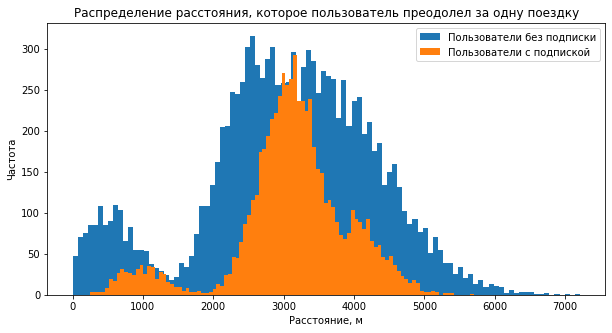

In [38]:
plt.figure(figsize=[10, 5])

without_subscription['distance'].plot(kind='hist', bins=100, label='Пользователи без подписки')
with_subscription['distance'].plot(kind='hist', bins=100, label='Пользователи с подпиской')


plt.title('Распределение расстояния, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние, м')
plt.ylabel('Частота')
plt.legend()

plt.show()

Из приведенных выше графиков можно сделать вывод о том, что поездки у пользователей без подписки в среднем такие же по расстоянию, как и у пользователей с подпиской.

Однако можно заметить, что пользователи без подписки совершают более разнообразные по расстоянию поездки, чем пользователи с подпиской.

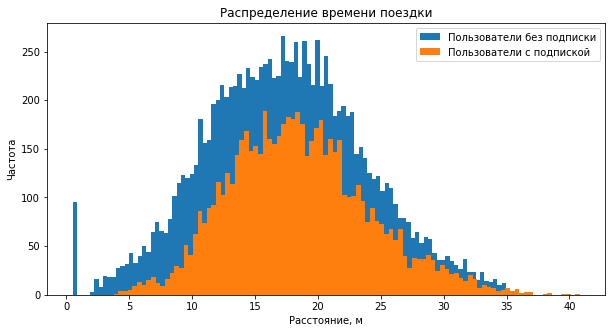

In [39]:
plt.figure(figsize=[10, 5])

without_subscription['duration'].plot(kind='hist', bins=100, label='Пользователи без подписки')
with_subscription['duration'].plot(kind='hist', bins=100, label='Пользователи с подпиской')

plt.title('Распределение времени поездки')
plt.xlabel('Расстояние, м')
plt.ylabel('Частота')
plt.legend()

plt.show()

Из приведенных выше графиков можно сделать вывод о том, что поездки у пользователей без подписки в среднем длятся столько же, сколько у пользователей с подпиской.

Тем не менее, распределение времени поездки у пользователей без подписки обладает большим разбросом.

Также на графике пользователей без подписки можно увидеть резкий рост числа поездок длительностью менее минуты. Это может быть связано с тем, что пользователи приняли решение отказаться от аренды самоката и завершить поездку.

## Подсчёт выручки

Сгруппируем данные о поездках и найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [40]:
data_rounded = data.copy() #создадим копию датафрейма для внесения изменений, нужных для расчета
data_rounded['duration'] = np.ceil(data_rounded['duration']) #округлим время поездки вверх

data_by_user = data_rounded.groupby(['user_id', 'month']).agg({'distance':['sum', 'count'], 'duration':'sum',\
                'subscription_type':'first', 'minute_price':'first', 'start_ride_price': 'first', 'subscription_fee': 'first'})

data_by_user.columns = ['total_distance', 'n_of_rides', 'total_duration', 'subscription_type', 'minute_price',\
                        'start_ride_price', 'subscription_fee']

data_by_user.reset_index(inplace=True)

data_by_user.head(20)

,user_id,month,total_distance,n_of_rides,total_duration,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,7027.511294,2,42.0,ultra,6,0,199
1,1,4,754.159807,1,7.0,ultra,6,0,199
2,1,8,6723.470560,2,46.0,ultra,6,0,199
3,1,10,5809.911100,2,32.0,ultra,6,0,199
4,1,11,7003.499363,3,56.0,ultra,6,0,199
5,1,12,6751.629942,2,28.0,ultra,6,0,199
6,2,3,10187.723006,3,63.0,ultra,6,0,199
7,2,4,6164.381824,2,40.0,ultra,6,0,199
8,2,6,3255.338202,1,14.0,ultra,6,0,199
9,2,7,6780.722964,2,48.0,ultra,6,0,199


Проверим полученные данные на предмет пропущенных значений.

In [41]:
data_by_user.isnull().sum()

user_id              0
month                0
total_distance       0
n_of_rides           0
total_duration       0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Теперь, когда мы убедились в отсутствии пропусков, рассчитаем помесячную выручку для каждого пользователя.

In [42]:
data_by_user['monthly_income'] = data_by_user['start_ride_price'] * data_by_user['n_of_rides'] +\
                                data_by_user['minute_price'] * data_by_user['total_duration'] + data_by_user['subscription_fee']
data_by_user.sample(10)

,user_id,month,total_distance,n_of_rides,total_duration,subscription_type,minute_price,start_ride_price,subscription_fee,monthly_income
2941,452,4,9028.591624,3,57.0,ultra,6,0,199,541.0
5346,803,6,8625.882843,3,34.0,free,8,50,0,422.0
4857,739,5,3710.812442,1,25.0,free,8,50,0,250.0
7482,1066,1,2809.064949,1,19.0,free,8,50,0,202.0
8744,1219,5,3990.563878,2,26.0,free,8,50,0,308.0
3829,585,11,7462.539382,2,38.0,ultra,6,0,199,427.0
4529,699,8,7018.324143,2,45.0,ultra,6,0,199,469.0
11227,1523,7,4054.727558,1,32.0,free,8,50,0,306.0
1421,220,1,4519.479089,2,24.0,ultra,6,0,199,343.0
3308,509,3,2916.843079,1,11.0,ultra,6,0,199,265.0


## Проверка гипотез

Для проверки гипотез установим уровень статистической значимости в 5%.

In [43]:
alpha = 0.01

### 1. Пользователи с подпиской тратят больше времени на поездки

Данные в нашем распоряжении - это выборка о некоторых пользователях из нескольких городов из общей совокупности данных сервиса. Данные о пользователях без подписки в датафрейме `without_subscription` можно считать выборкой из генеральной совокупности пользователей сервиса без подписки, а данные о пользователях с подпиской в датафрейме `with_subscription` - выборкой из генеральной совокупности пользователей сервиса с подпиской.


Поэтому для проверки данной гипотезы проведем односторонний t-test среднего двух независимых генеральных совокупностей по взятым из них выборкам.

* Нулевая гипотеза: Пользователи в среднем тратят одинаковое количество времени на поездки вне зависимости от наличия подписки.
* Альтернативная гипотеза: Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.

In [44]:
hyp1 = st.ttest_ind(with_subscription['duration'], without_subscription['duration'], alternative='greater')

print('p-значение:', hyp1.pvalue)

if hyp1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


В результате проведения теста мы отвергаем нулевую гипотезу. Следовательно, есть достаточно статистических оснований полагать, что пользователи с подпиской тратят больше времени на поездки.

### 2. Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 метров

В данном случае нас интересует генеральная совокупность пользователей с подпиской, которой соответствует выборка `with_subscription`.

Для проверки данной гипотезы проведем односторонний t-test среднего генеральной совокупности пользователей сервиса с подпиской.

* Нулевая гипотеза: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, составляет 3130 метров.
* Альтернативная гипотеза: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 метров.

In [45]:
target_distance = 3130

hyp2 = st.ttest_1samp(with_subscription['distance'], target_distance, alternative='greater')

print('p-значение:', hyp2.pvalue)

if hyp2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


В результате проведения теста не получилось отвергнуть нулевую гипотезу. Следовательно, нет достаточно статистических оснований полагать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 метров.

Соответственно, самокаты, которые предоставляет сервис, оптимальные с точки зрения износа.

### 3. Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки

В данном случае мы будем использовать агрегированные данные по каждому пользователю в датафреме `data_by_user` для сравнения средней помесячной выручки генеральной совокупности пользователей с подпиской и генеральной совокупности пользователей без нее.

Для этого нужно будет разделить датафрейм на данные о пользователях с подпиской и без нее, а затем провести односторонний t-test среднего двух независимых генеральных совокупностей по взятым из них выборкам.

* Нулевая гипотеза: Помесячная выручка в среднем одинаковая от пользователей с подпиской и от пользователей без нее.
* Альтернативная гипотеза: Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

In [46]:
data_by_user_with_subscription = data_by_user.query('subscription_type == "ultra"')

data_by_user_without_subscription = data_by_user.query('subscription_type == "free"')

hyp3 = st.ttest_ind(data_by_user_with_subscription['monthly_income'], data_by_user_without_subscription['monthly_income'],\
                    alternative='greater')

print('p-значение:', hyp3.pvalue)

if hyp3.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


В результате проведения теста мы отвергаем нулевую гипотезу. Следовательно, есть достаточно статистических оснований полагать, что помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.

В связи с этим, целесообразно будет продвигать подписку среди пользователей с целью увеличения числа подписчиков.

### 4. Проведение теста по результатам обновления сервера

Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение, с целью снижения количества обращений в техподдержку.

В качестве необходимых данных предоставлен файл, который содержит для каждого пользователя данные о количестве обращений до обновления и после него.

Для проверки гипотезы технической команды необходимо будет провести двусторонний t-test среднего двух зависимых генеральных совокупностей по взятым из них выборкам. Выборки в этом случае будут парными. Парная выборка означает, что количество обращений в поддержку измеряется дважды (до и после обновления) для одних и тех же пользователей.

* Нулевая гипотеза: В среднем количество обращений в техподдержу до и после обновления одинаковое.
* Альтернативная гипотеза: Количество обращений в техподдержку значимо снизилось после обновления.

Код выполнения будет примерно следующим:

hyp4 = st.ttest_rel(*данные до обновления*, *данные после обновления*, alternative='less')

print('p-значение:', hyp4.pvalue)

if hyp4.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
    
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

## Общий вывод

Для проведения исследования были использованы датафреймы с данными о более, чем 1.5 тысячах пользователей, и более, чем 18 тысячах поездок, что является достаточно большой базой для проверки гипотез и формирования выводов.

В ходе предобработки данных были изменены типы данных, добавлены столбцы с дополнительной информацией и удалены дубликаты пользователей.

В процессе исследовательского анализа мы убедились в качестве данных - количественные данные имеют нормальное распределение, а пользователи равномерно распределены между городами и типами подписок.

Далее мы объединили датафреймы в один и выделили в нем пользователей с подпиской и без нее. Оказалось, что в среднем расстояние и время поездки в этих категориях одинаковое, но пользователи с подпиской с большей гибкостью используют сервис и выбирают самокат как для долгих, так и для коротких поездок. Эту закономерность можно использовать при продвижении подписки среди пользователей.

После этого мы подсчитали помесячную выручку от каждого пользователя и приступили к проверке гипотез.

В результате проверки гипотез мы выяснили, что пользователи с подпиской тратят больше времени на поездки и приносят больше ежемесячной выручки, чем пользователи без нее. Следовательно для бизнеса будет целесообразно продвигать подписку среди пользователей с целью увеличения числа подписчиков.